In [1]:
import torch.nn as nn
import lightning as L
import torch
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [2]:
class AutoEncoder(L.LightningModule):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
            super().__init__()
            c_hid = base_channel_size
            self.encoder = nn.Sequential(
                nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 408x408 => 204x204
                act_fn(),
                nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=2), # 408x408 => 102x102
                act_fn(),
                nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 102x102 => 53x53
                act_fn(),
                nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2), # 102x102 => 27x27
                act_fn(),
                nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 25x25 => 12x12
                act_fn(),
                nn.Flatten(),  # Image grid to single feature vector
                nn.Linear(2 * 169 * c_hid, latent_dim),
            )
            self.linear_decoder = nn.Sequential(
                nn.Linear(latent_dim, 2 * 169 * c_hid),
                act_fn()
            )
            self.decoder = nn.Sequential( 
                act_fn(),
                nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 12x12 => 25x25
                act_fn(),
                nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=0, padding=1, stride=2),  # 25x25 => 51x51
                act_fn(),
                nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 51x51 => 102x102
                act_fn(),
                nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 102x102 => 204x204
                act_fn(),
                nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),  # 204x204 => 408x408
                nn.Sigmoid()
            )
    def forward(self, x):
        x_ae = self.encoder(x)
        x_rec = self.linear_decoder(x_ae).reshape(x_ae.shape[0], -1, 13, 13)
        return self.decoder(x_rec)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        x_rec = self.linear_decoder(x).reshape(x.shape[0], -1, 13, 13)
        return self.decoder(x_rec)

    def get_reconstruction_loss(self, x):
        x_pred = self.forward(x)
        loss = torch.nn.functional.mse_loss(x, x_pred, reduction = "none")
        return loss.mean()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch):
        x, _ = batch
        loss = self.get_reconstruction_loss(x)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch):
        x, _ = batch
        loss = self.get_reconstruction_loss(x)
        self.log("val_loss", loss)
        return loss

# Look at reconstruction

In [3]:
model = AutoEncoder.load_from_checkpoint('logs/lightning_logs/1000/epoch=399-step=9200.ckpt', num_input_channels=1, base_channel_size=24, latent_dim=1000)

C:\Users\emman\AppData\Roaming\Python\Python39\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.2.5, which is newer than your current Lightning version: v2.2.4


In [4]:
cmaps = os.listdir('cmaps')
maps = []
length = []
for map in cmaps:
    max_size = 408
    im_reshape = np.zeros((max_size, max_size))
    im = np.asarray(Image.open(os.path.join('cmaps', map)))
    im_correct = im[im.any(axis=1)][:, im.any(axis=0)]
    n, p = im_correct.shape
    length.append(n)
    # The data is rescalde between 0 and 1
    im_rescale = - (im_correct / 255) + 1
    # Center and reshape the data
    im_rescale = np.pad(im_rescale, [((max_size - n) // 2, (max_size - n) - (max_size - n) // 2), ((max_size - p) // 2, (max_size - p) - (max_size - p) // 2)])
    maps.append(im_rescale[None,:,:].astype(np.float32))

In [5]:
maps = torch.tensor(np.array(maps), dtype=torch.float32)

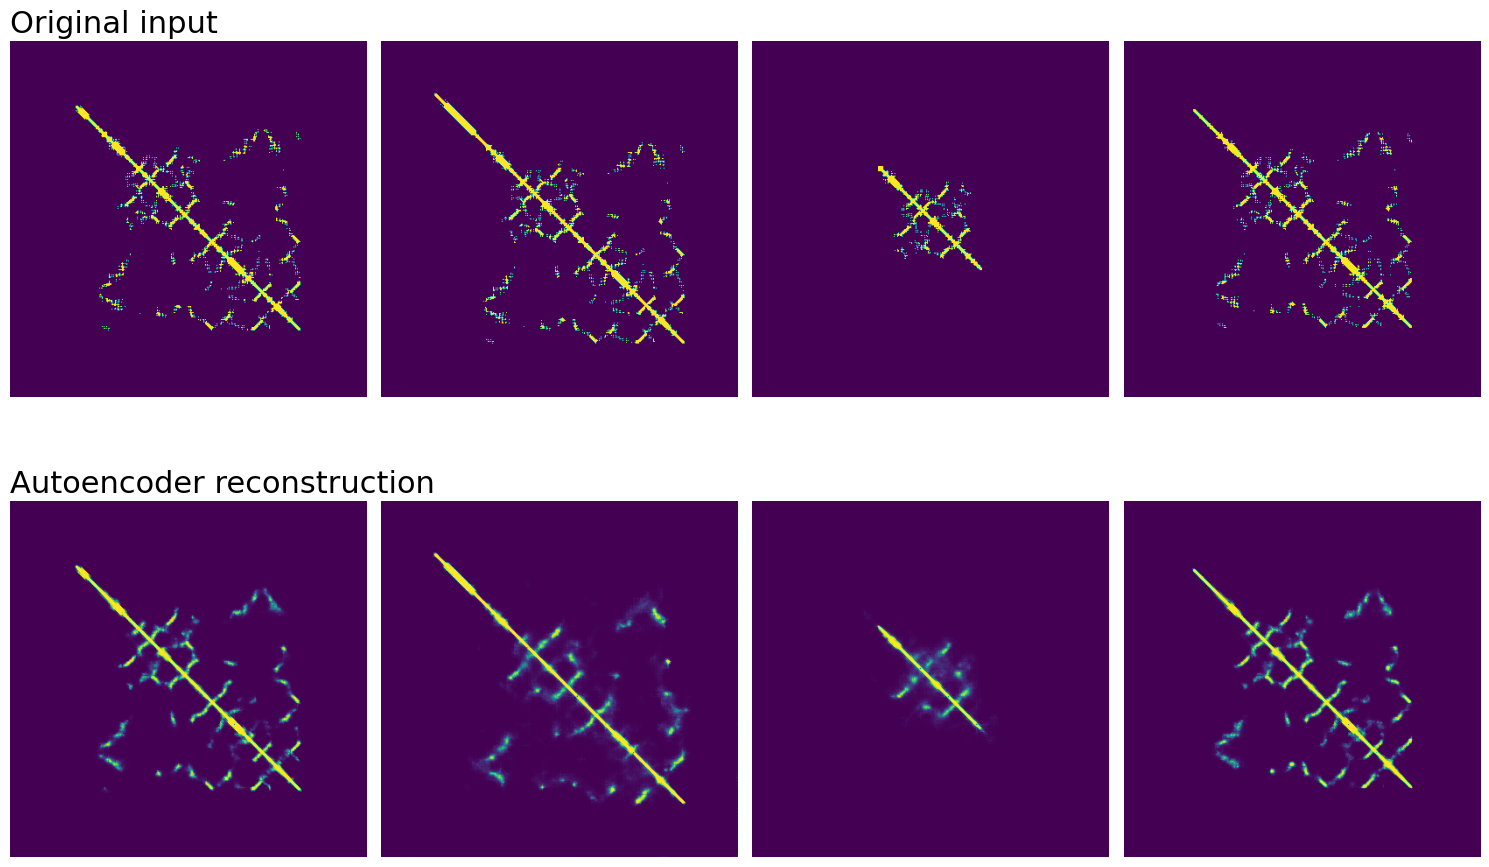

In [59]:
samples = np.random.choice(range(len(maps)), 4)
fig, ax = plt.subplots(2, 4, figsize = (15,10))
for j in range(len(ax[0])):
    ax[0,j].set_aspect('equal')
    ax[0,j].imshow(maps[j][0])
    ax[0,j].axis('off')
    pred = model.forward(maps[j].unsqueeze(dim=0)).detach().numpy()
    ax[1,j].set_aspect('equal')
    ax[1,j].imshow(pred[0,0])
    ax[1,j].axis('off')
ax[0,0].set_title("Original input", size=22, loc='left')
ax[1,0].set_title("Autoencoder reconstruction", size=22, loc='left')
plt.tight_layout()
plt.show()

## PCA Analysis

In [7]:
encoded = model.encode(maps)

In [8]:
encoded = encoded.detach().numpy()
U,V,D = np.linalg.svd(encoded)

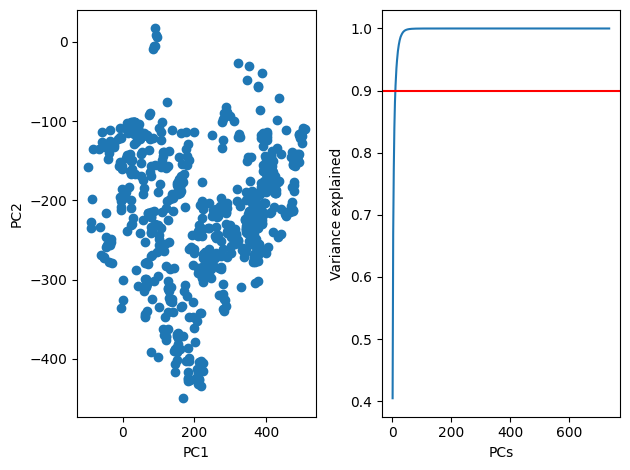

In [9]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(encoded @ D[:,0], encoded @ D[:,1])
ax[1].plot(np.arange(V.shape[0]) + 1, np.cumsum(V ** 2) / np.sum(V ** 2))
ax[1].axhline(0.9, c = 'red')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_xlabel('PCs')
ax[1].set_ylabel('Variance explained')
plt.tight_layout()
plt.savefig('pcs_projection.png')
plt.show()

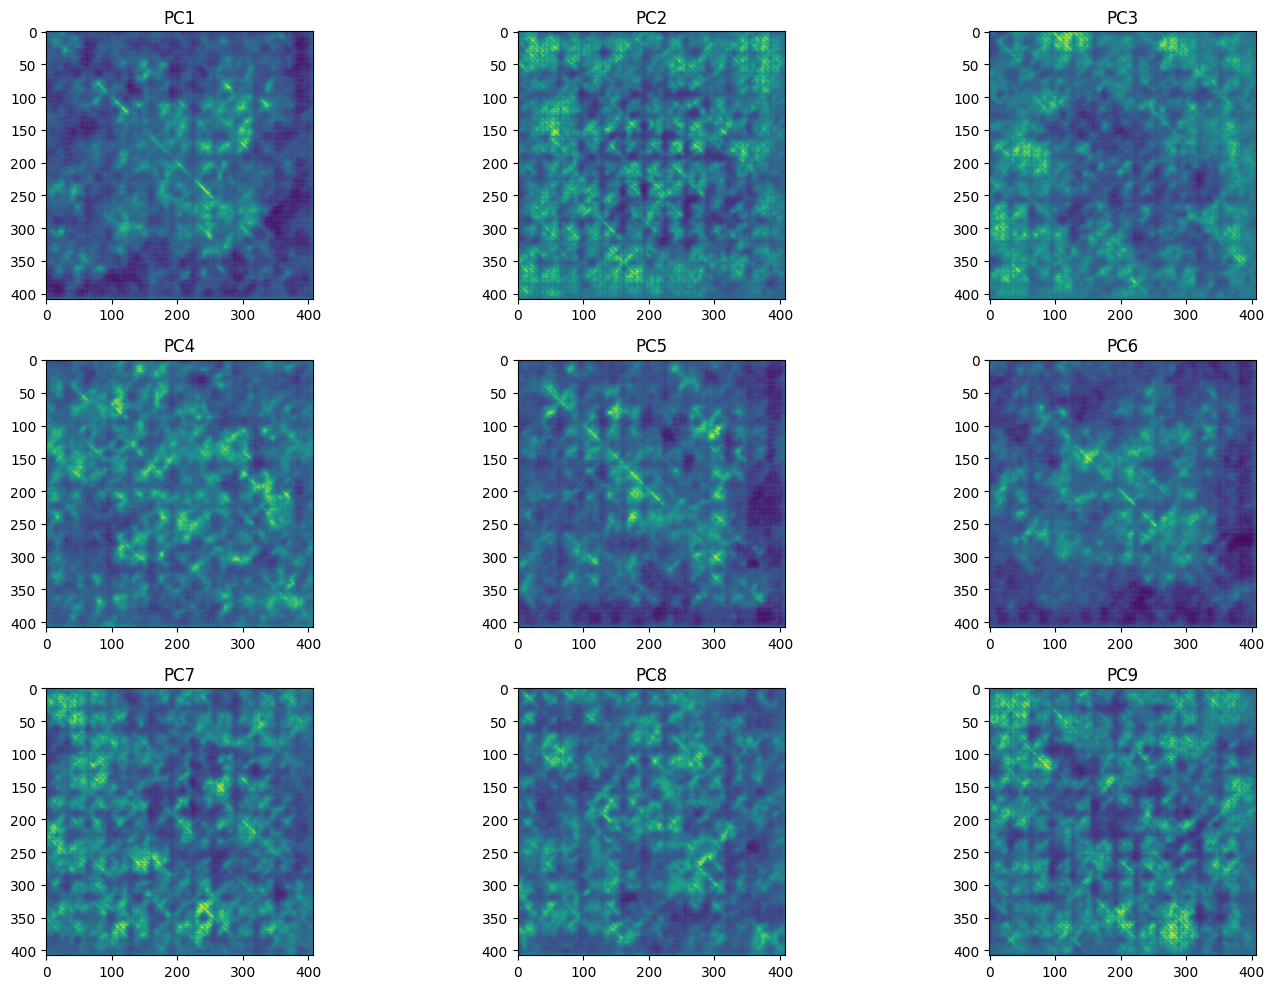

In [10]:
fig, ax = plt.subplots(3, 3, figsize = (15,10))

for j in range(ax.shape[0]*ax.shape[1]):
    ax[j//3, j%3].set_aspect('equal')
    # rescaling PCs to get interpretable clusters
    pred = model.decode(1000 * torch.tensor(D[:,j]).unsqueeze(dim=0)).detach().numpy()
    ax[j//3, j%3].imshow(pred[0,0])
    ax[j//3, j%3].set_title(f'PC{j+1}')

plt.tight_layout()
plt.show()

## VGG16 vs AE vs Naive clustering

In [11]:
v116_features = np.load('features_v166.npz')['features']
flatten_maps = maps.reshape(737,-1)

In [12]:
from sklearn.cluster import KMeans
kmeans_ae = KMeans(n_clusters = 5, init = "random", n_init = 10, random_state = 0).fit(encoded)
cluster_des_ae = kmeans_ae.fit_predict(encoded)
kmeans_v116 = KMeans(n_clusters = 5, init = "random", n_init = 10, random_state = 0).fit(v116_features)
cluster_des_v116 = kmeans_v116.fit_predict(v116_features)
kmeans_naive = KMeans(n_clusters = 5, init = "random", n_init = 10, random_state = 0).fit(flatten_maps)
cluster_des_flatten = kmeans_naive.fit_predict(flatten_maps)
U_v, V_v, D_v = np.linalg.svd(v116_features)

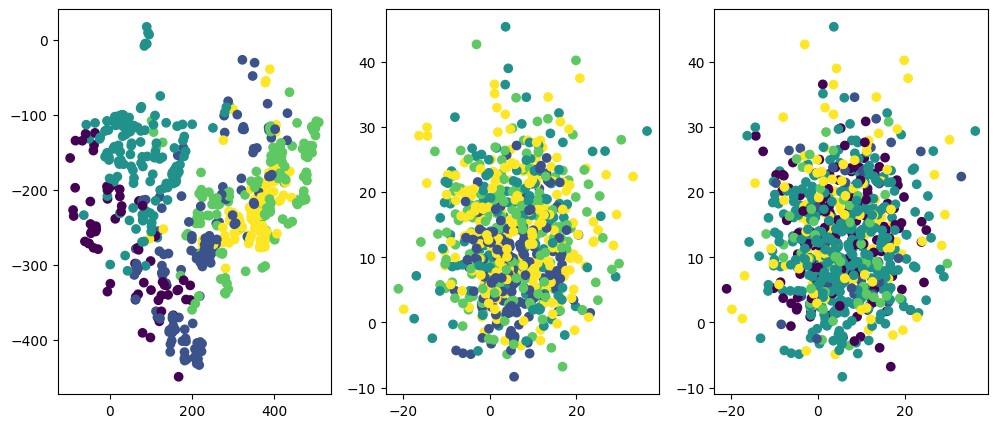

In [13]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(12,5)
ax[0].scatter(encoded @ D[:,0], encoded @ D[:,1], c = cluster_des_ae / max(cluster_des_ae))
ax[1].scatter(v116_features @ D_v[:,0], v116_features @ D_v[:,1], c = cluster_des_v116 / max(cluster_des_v116))
ax[2].scatter(v116_features @ D_v[:,0], v116_features @ D_v[:,1], c = cluster_des_flatten / max(cluster_des_flatten))
plt.show()

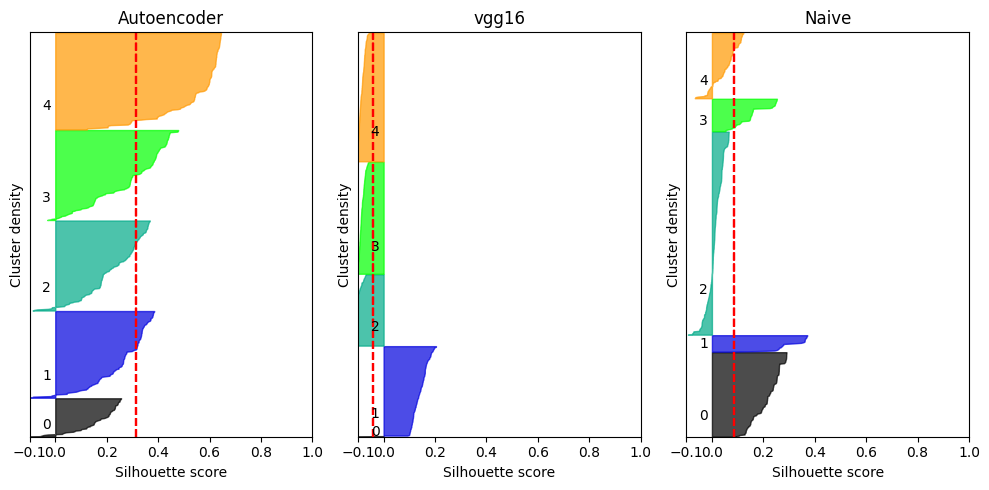

In [14]:
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 5)   
n_clusters = 5
for idx,j in enumerate([[encoded,cluster_des_ae, 'Autoencoder'], [v116_features,cluster_des_v116, 'vgg16'], [flatten_maps,cluster_des_flatten, 'Naive']]):
    silhouette_sampl = silhouette_samples(j[0], j[1])
    silhouette_scores = silhouette_score(j[0], j[1])
    space = 0
    y_lower = 0
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = silhouette_sampl[j[1] == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        # drawing silhouettes
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax[idx].set_ylim([-0.1, len(j[0]) + (n_clusters + 1) * space + 0.1])
        ax[idx].set_xlim([-0.1, 1])
        y_upper = y_lower + size_cluster_i
        ax[idx].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax[idx].axvline(silhouette_scores, color = 'red', linestyle = 'dashed')

        # Label the silhouette plots with their cluster numbers at the middle
        ax[idx].set_yticks([])  # Clear the yaxis labels / ticks
        ax[idx].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        ax[idx].text(-0.05, y_lower + 0.2 * size_cluster_i, str(i))
        ax[idx].set_xlabel('Silhouette score')
        ax[idx].set_ylabel('Cluster density')
        ax[idx].set_title(j[2])
        y_lower = y_upper + space
plt.tight_layout()
plt.show()

## Correlation between clusters and domain classes

In [90]:
import pandas as pd
import ast
cmaps = np.array([cmap.removesuffix('_origin.png') for cmap in cmaps])
data = pd.read_csv('InterPro_output_forannotation_new.csv', delimiter = ";")
intersec = np.intersect1d(np.array(cmaps), data['acno'])
data = data[data['acno'].isin(intersec)].reset_index(drop=True)
data['acno'] = pd.Categorical(data['acno'], categories=cmaps, ordered=True)
data = data.sort_values('acno')
dboxes = [ast.literal_eval(i) for i  in data['interval'].values]
domains = pd.get_dummies(data, columns = ['domain']).drop('interval', axis=1).values
domain_names = pd.get_dummies(data, columns=['domain']).columns[2:9].values
domain_names = [domain.replace('domain_','') for domain in domain_names]

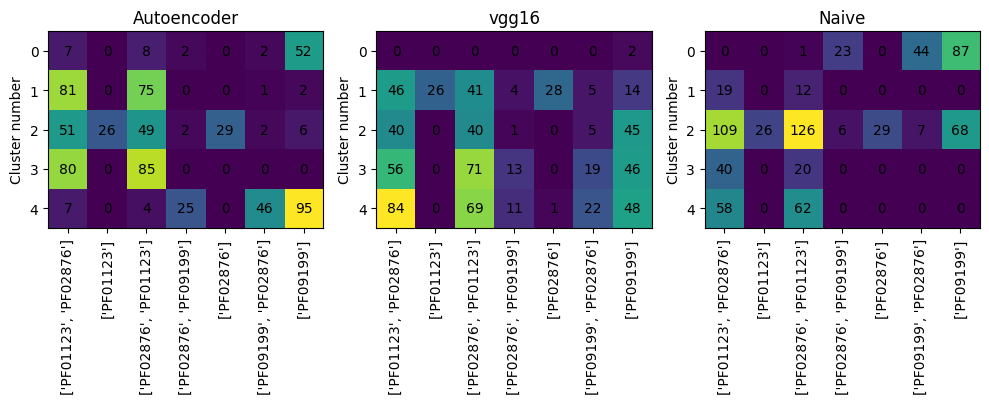

In [16]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 7) 
for idx_plt,k in enumerate([['Autoencoder',cluster_des_ae], ['vgg16',cluster_des_v116], ['Naive',cluster_des_flatten]]):
    final_map = []
    for i in range(n_clusters):
        domains_count = np.sum(domains[k[1] == i, 1:], axis = 0)
        final_map.append(domains_count)
        for idx, j in enumerate(domains_count):
            ax[idx_plt].text(idx, i, j, ha="center", va="center")
    ax[idx_plt].set_title(k[0])
    ax[idx_plt].set_xticks(ticks = range(7), labels=domain_names, rotation = 90)
    ax[idx_plt].set_ylabel('Cluster number')
    ax[idx_plt].imshow(np.array(final_map).astype(float))
plt.tight_layout()
plt.show()

In [94]:
import pandas as pd
data = pd.read_csv('filtered_labels.csv')
data['Name'] = pd.Categorical(data['Name'], categories=cmaps, ordered=True)
data = data.sort_values('Name')
domains = pd.get_dummies(data, columns=['Domain']).values[:,1:]
domains_names = pd.get_dummies(data, columns=['Domain']).columns[1:].values
domains_names = [domain.replace('Domain_','') for domain in domains_names]

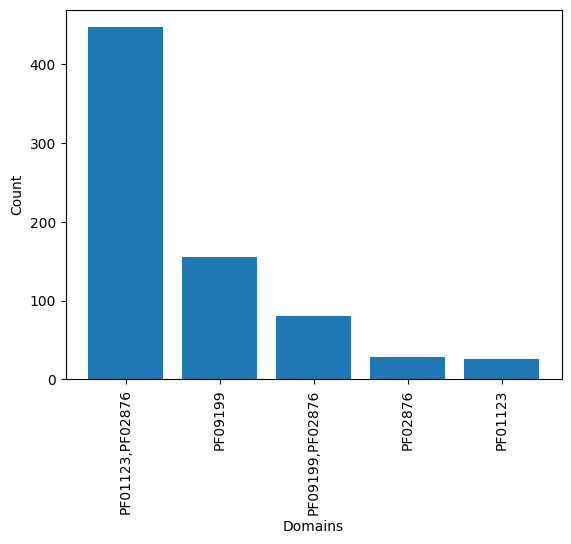

In [48]:
# Domain labels distribution
names, count = data['Domain'].value_counts().index, data['Domain'].value_counts().values
plt.bar(names,count)
plt.xticks(rotation=90)
plt.xlabel('Domains')
plt.ylabel('Count')
plt.show()

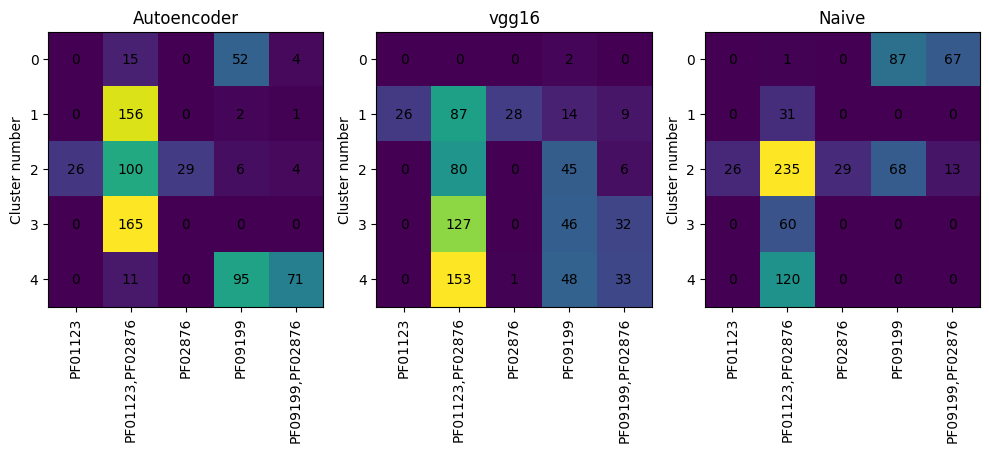

In [18]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 7) 
n_clusters = 5
for idx_plt,k in enumerate([['Autoencoder',cluster_des_ae], ['vgg16',cluster_des_v116], ['Naive',cluster_des_flatten]]):
    final_map = []
    for i in range(n_clusters):
        domains_count = np.sum(domains[k[1] == i], axis = 0)
        final_map.append(domains_count)
        for idx, j in enumerate(domains_count):
            ax[idx_plt].text(idx, i, j, ha="center", va="center")
    ax[idx_plt].set_title(k[0])
    ax[idx_plt].set_xticks(ticks = range(5), labels=domains_names, rotation = 90)
    ax[idx_plt].set_ylabel('Cluster number')
    ax[idx_plt].imshow(np.array(final_map).astype(float))
plt.tight_layout()
plt.show()

## Length correlation

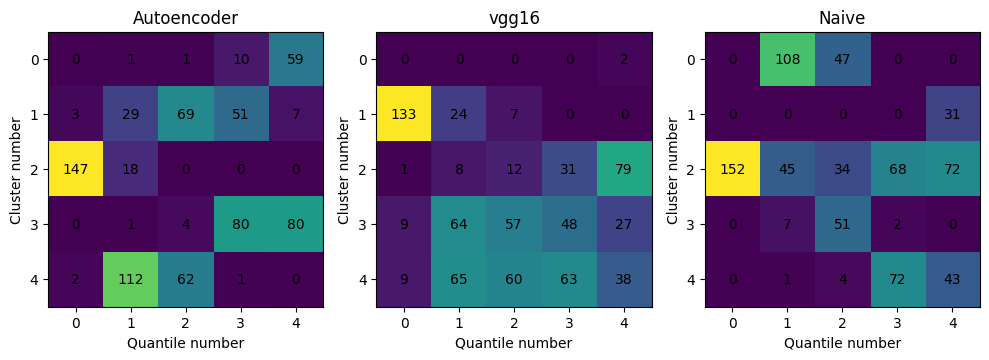

In [19]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 7) 
n_clusters = 5
n_quantiles = 5
length = np.array(length)
border = np.quantile(length, np.linspace(0,1,n_quantiles+1))
for idx_plt,k in enumerate([['Autoencoder',cluster_des_ae], ['vgg16',cluster_des_v116], ['Naive',cluster_des_flatten]]):
    final_map = []
    for i in range(n_clusters):
        quantile_count = []
        length_cluster = length[k[1] == i]
        quantile_count.append(np.sum(length_cluster <= border[1]))
        for s in range(1,len(border)-1):
            quantile_count.append(np.sum((length_cluster > border[s]) & (length_cluster <= border[s+1])))
        final_map.append(quantile_count)
        for idx, j in enumerate(quantile_count):
            ax[idx_plt].text(idx, i, j, ha="center", va="center")
    ax[idx_plt].set_title(k[0])
    ax[idx_plt].set_xticks(ticks = range(n_quantiles), labels=np.arange(n_quantiles))
    ax[idx_plt].set_ylabel('Cluster number')
    ax[idx_plt].set_xlabel('Quantile number')
    ax[idx_plt].imshow(np.array(final_map).astype(float))
plt.tight_layout()
plt.show()

## Samples

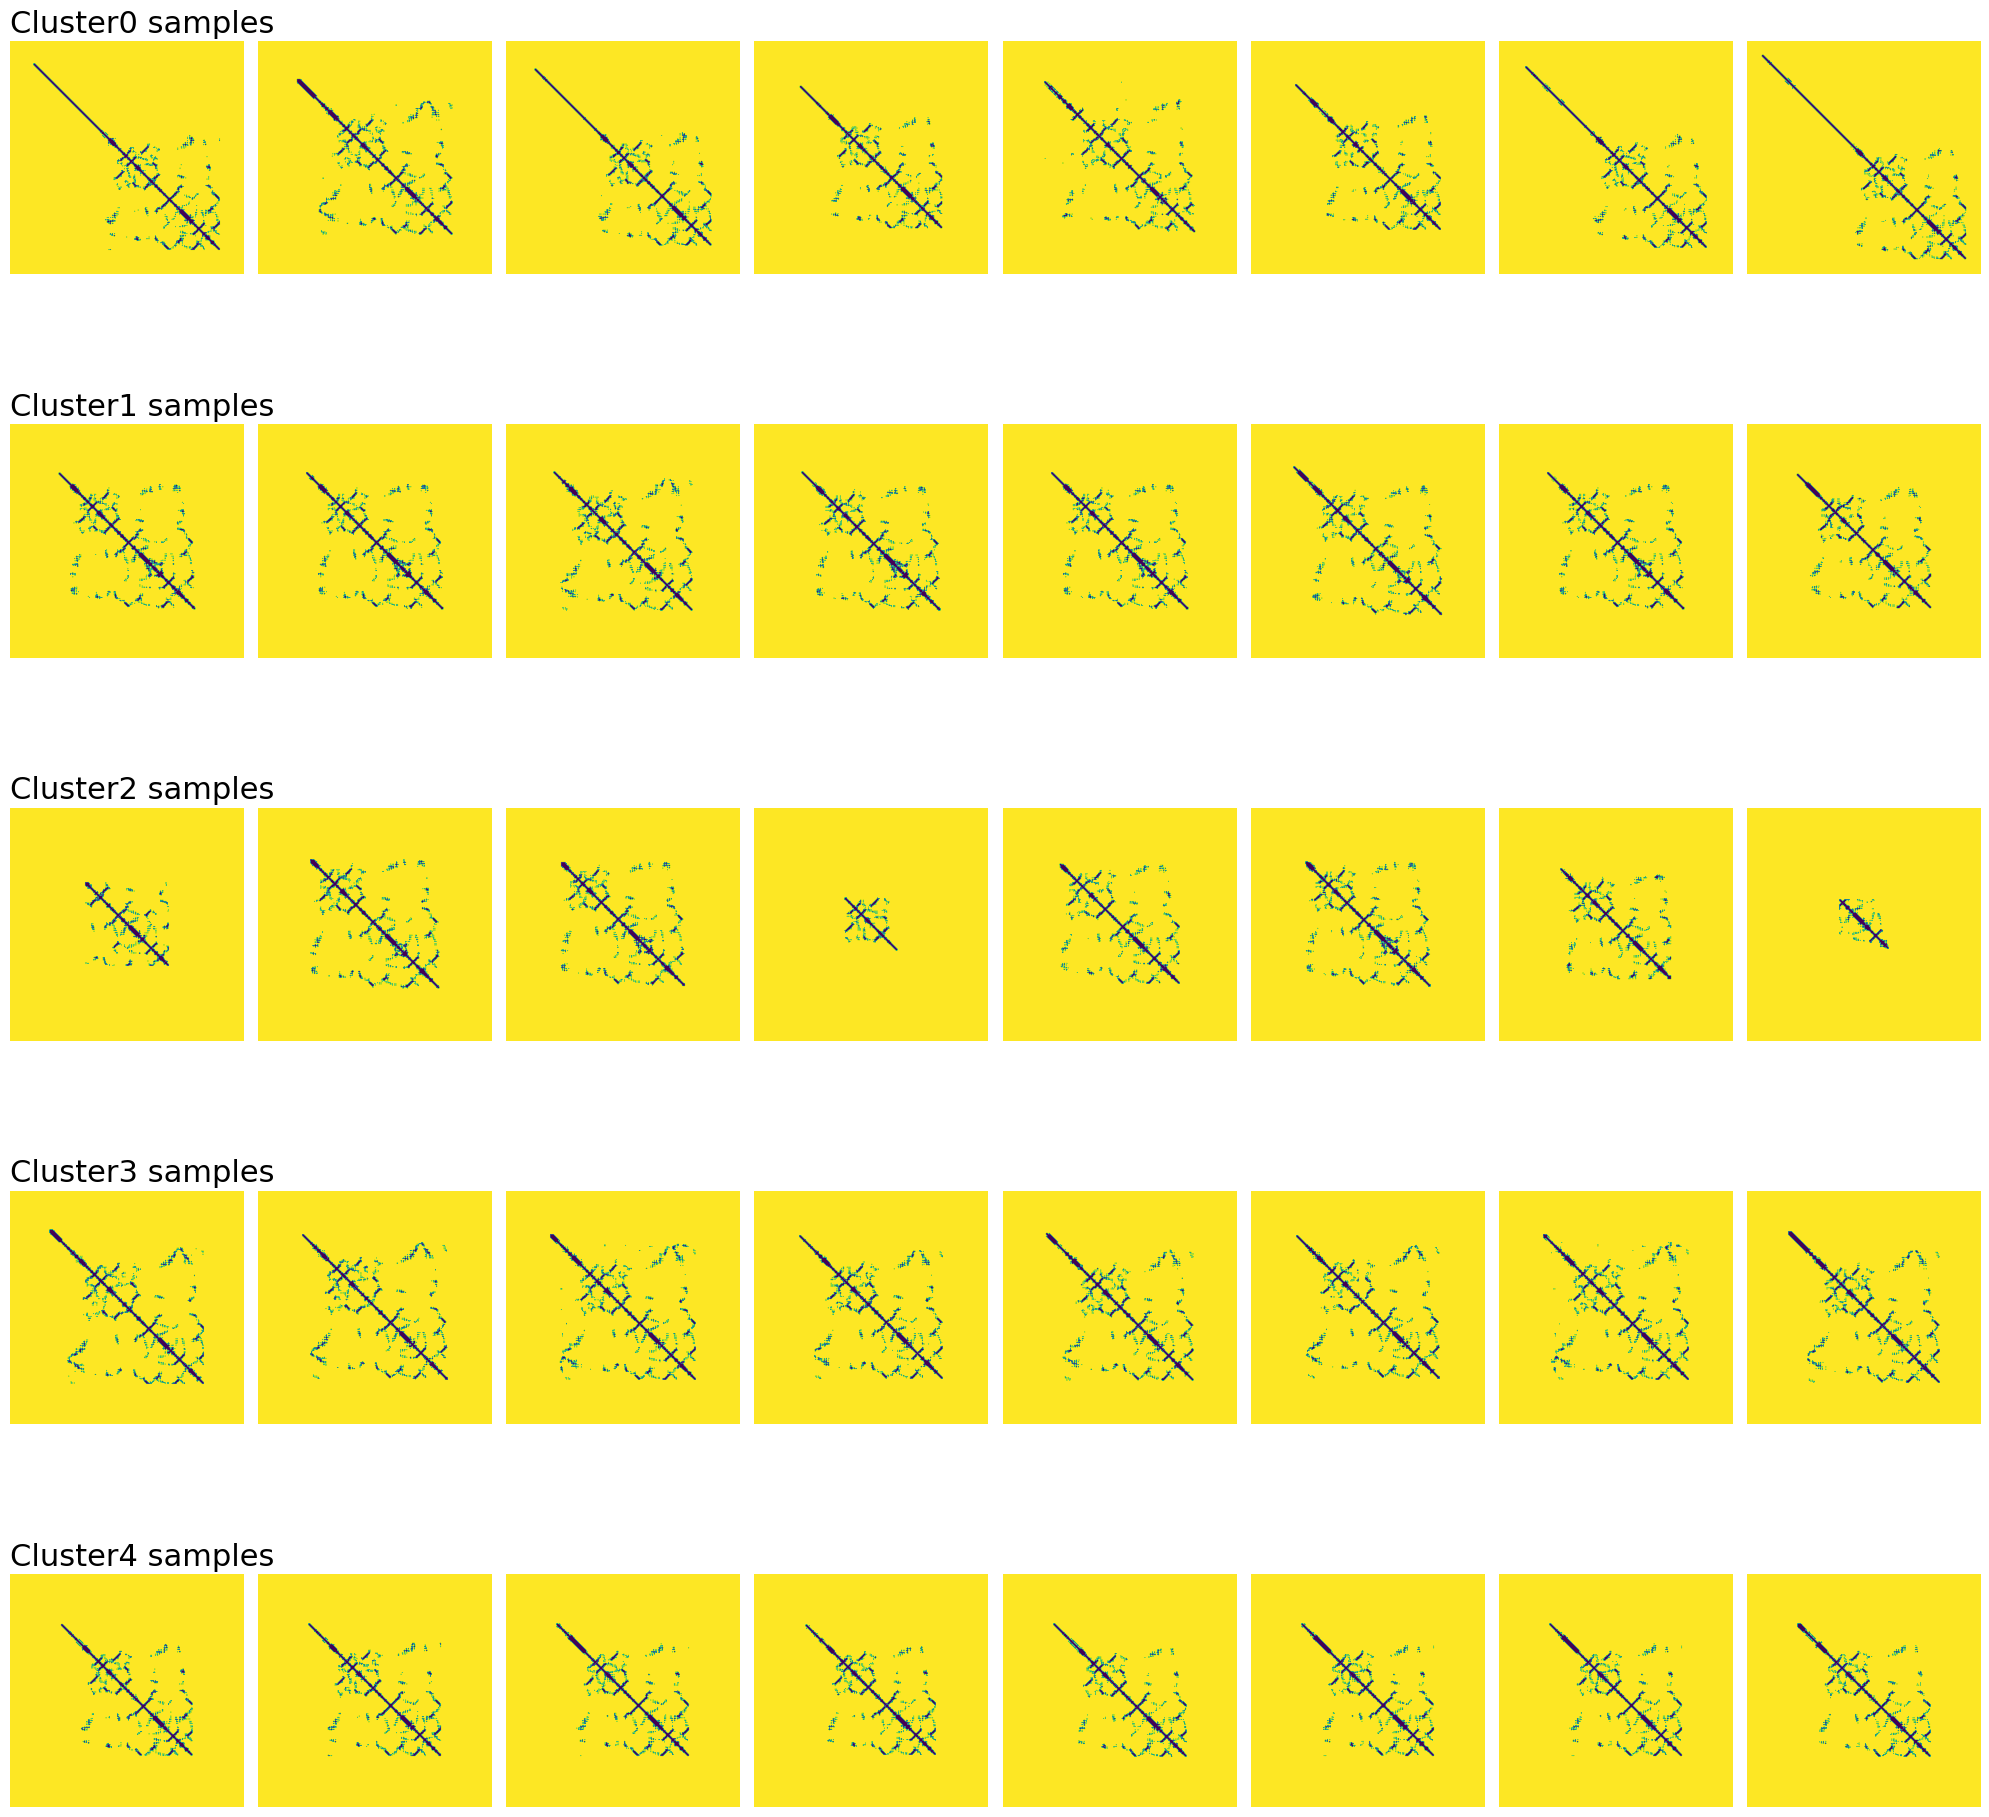

In [51]:
n_clusters = 5
n_samples = 8
fig, ax = plt.subplots(n_clusters, n_samples, figsize=(20,20))
index = np.arange(len(cmaps))
for i in range(n_clusters):
    samples = np.random.choice(index[cluster_des_ae == i], size=8, replace=False)
    ax[i,0].set_title(f'Cluster{i} samples', loc = 'left', size=22)
    for j, map in enumerate(samples):
        ax[i,j].imshow(-255 * (maps[map][0] - 1))
        ax[i,j].axis('off')
plt.tight_layout()
plt.show()


## Missclassified samples

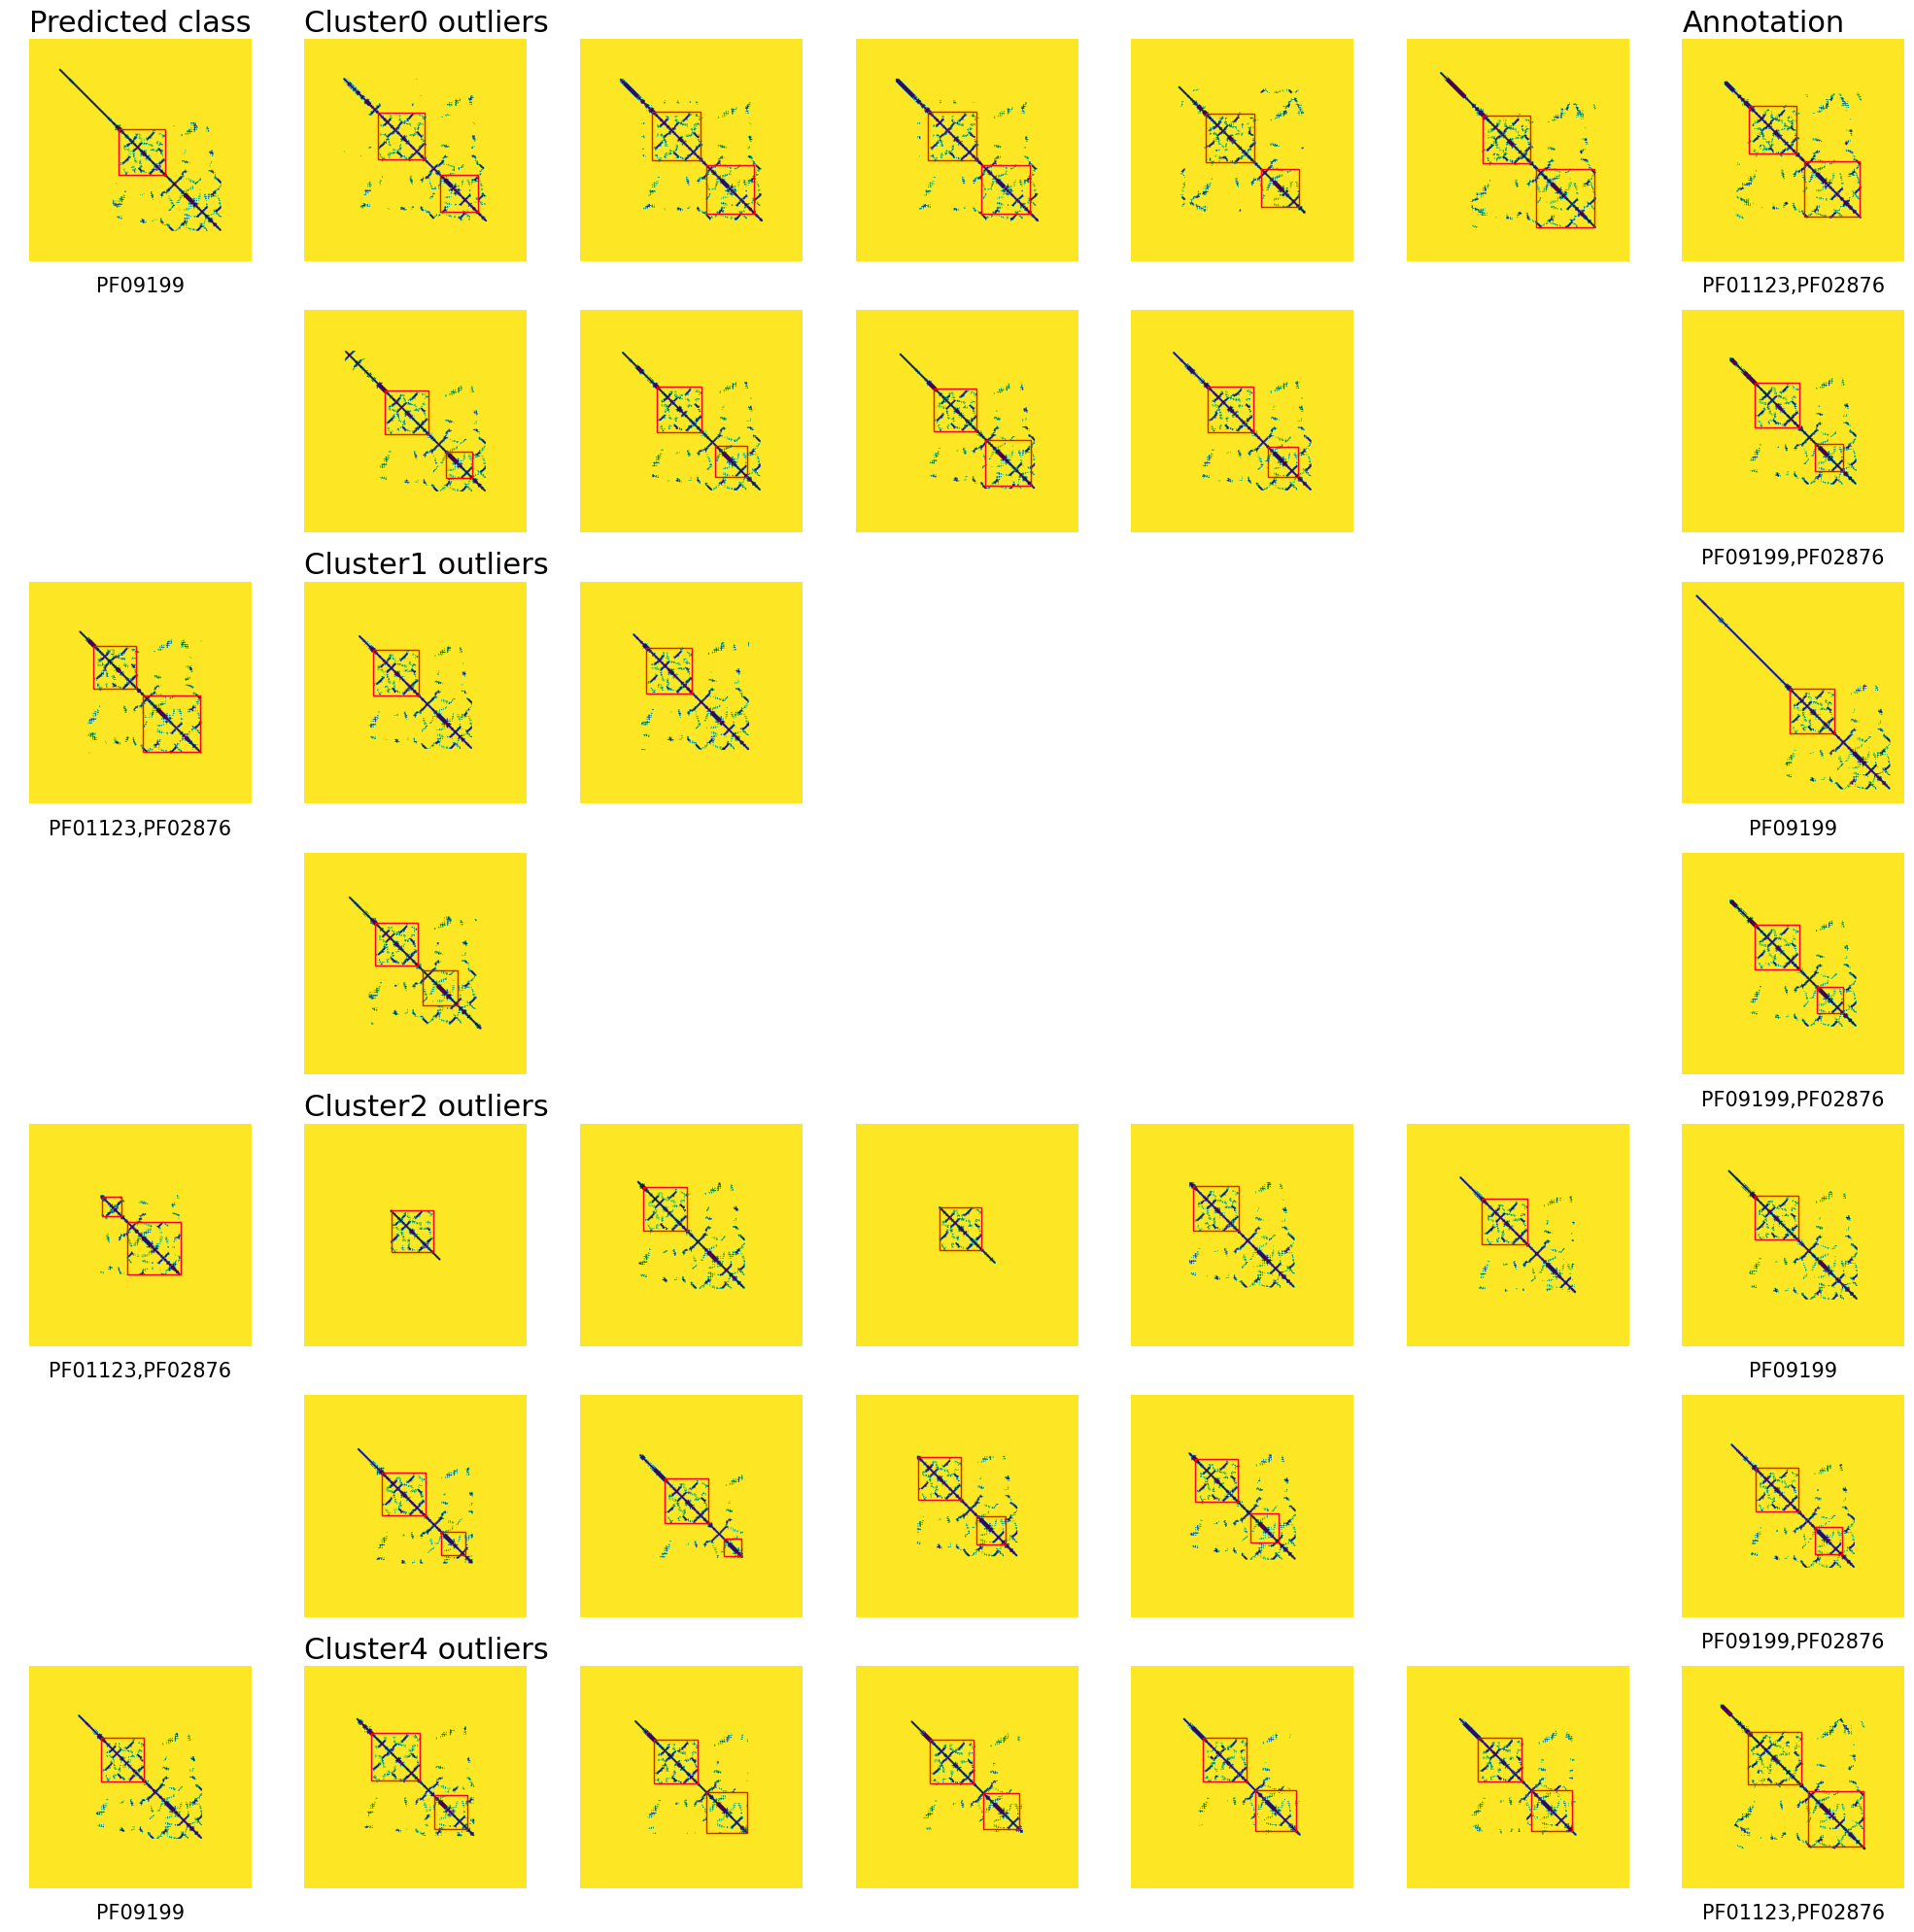

In [114]:
from matplotlib.patches import Rectangle
# According to our clustering model these samples should be labelled differently
final_map = []
for i in range(n_clusters):
    domains_count = np.sum(domains[cluster_des_ae == i], axis = 0)
    final_map.append(domains_count)
low_area = np.where((final_map / np.sum(final_map,axis=0) < 0.1) & (final_map / np.sum(final_map,axis=0) > 0))
fig, ax = plt.subplots(len(low_area[0]), 5 + 2, figsize = (20,20))
ax[0,0].set_title(f'Predicted class', loc = 'left', size=22)
ax[0,-1].set_title(f'Annotation', loc = 'left', size=22)
cluster_name = 0
for i, (cluster, clas) in enumerate(zip(low_area[0], low_area[1])):
        if i == 0:
            ax[i,1].set_title(f'Cluster{cluster_name} outliers', loc = 'left', size=22)
            count_class = np.unique(np.argmax(domains[cluster_des_ae == cluster], axis=1), return_counts=True)
            main_class = count_class[0][np.argmax(count_class[1])]
            main_sample = np.random.choice(index[(cluster_des_ae == cluster) & (np.argmax(domains, axis=1) == main_class)])
            ax[i,0].imshow(-255 * (maps[main_sample][0]-1))
            for j in dboxes[main_sample]:
                ax[i,0].add_patch(Rectangle(((max_size - length[main_sample])//2 + j[0], (max_size - length[main_sample])//2 + j[0]),
                                        j[1] - j[0],
                                        j[1] - j[0],
                                        fc = 'none',
                                        ec = 'red'
                ))
            ax[i, 0].spines['top'].set_visible(False)
            ax[i, 0].spines['right'].set_visible(False)
            ax[i, 0].spines['left'].set_visible(False)
            ax[i, 0].spines['bottom'].set_visible(False)
            ax[i, 0].tick_params(left=False, bottom=False)
            ax[i, 0].set_xticklabels([])
            ax[i, 0].set_yticklabels([])
            ax[i, 0].set_xlabel(domains_names[np.argmax(domains[main_sample])], size = 15)
        elif cluster != cluster_name:
            ax[i,1].set_title(f'Cluster{cluster} outliers', loc = 'left', size=22) 
            count_class = np.unique(np.argmax(domains[cluster_des_ae == cluster], axis=1), return_counts=True)
            main_class = count_class[0][np.argmax(count_class[1])]
            main_sample = np.random.choice(index[(cluster_des_ae == cluster) & (np.argmax(domains, axis=1) == main_class)])
            ax[i,0].imshow(-255 * (maps[main_sample][0]-1))
            cluster_name = cluster 
            for j in dboxes[main_sample]:
                ax[i,0].add_patch(Rectangle(((max_size - length[main_sample])//2 + j[0], (max_size - length[main_sample])//2 + j[0]),
                                        j[1] - j[0],
                                        j[1] - j[0],
                                        fc = 'none',
                                        ec = 'red'
                ))   
            ax[i, 0].spines['top'].set_visible(False)
            ax[i, 0].spines['right'].set_visible(False)
            ax[i, 0].spines['left'].set_visible(False)
            ax[i, 0].spines['bottom'].set_visible(False)
            ax[i, 0].tick_params(left=False, bottom=False)
            ax[i, 0].set_xticklabels([])
            ax[i, 0].set_yticklabels([])
            ax[i, 0].set_xlabel(domains_names[np.argmax(domains[main_sample])], size = 15)
        else:
            ax[i,0].axis('off')
        outliers = index[(cluster_des_ae == cluster) & (np.argmax(domains, axis=1) == clas)]
        samples = np.random.choice(outliers, size=min(5, len(outliers)), replace=False)
        for idx, map in enumerate(samples):
            ax[i,1 + idx].imshow(-255 * (maps[map][0]-1))
            ax[i,1 + idx].axis('off')
            for j in dboxes[map]:
                ax[i,1 + idx].add_patch(Rectangle(((max_size - length[map])//2 + j[0], (max_size - length[map])//2 + j[0]),
                                        j[1] - j[0],
                                        j[1] - j[0],
                                        fc = 'none',
                                        ec = 'red'
                ))   
        for idx in range(len(samples),5):
            ax[i,1 + idx].axis('off')
        class_sample = np.random.choice(index[(cluster_des_ae != cluster) & (np.argmax(domains, axis=1) == clas)])
        ax[i, -1].imshow(-255 * (maps[class_sample][0]-1))
        for j in dboxes[class_sample]:
            ax[i,-1].add_patch(Rectangle(((max_size - length[class_sample])//2 + j[0], (max_size - length[class_sample])//2 + j[0]),
                                    j[1] - j[0],
                                    j[1] - j[0],
                                    fc = 'none',
                                    ec = 'red'
            ))   
        ax[i, -1].spines['top'].set_visible(False)
        ax[i, -1].spines['right'].set_visible(False)
        ax[i, -1].spines['left'].set_visible(False)
        ax[i, -1].spines['bottom'].set_visible(False)
        ax[i, -1].tick_params(left=False, bottom=False)
        ax[i, -1].set_xticklabels([])
        ax[i, -1].set_yticklabels([])
        ax[i, -1].set_xlabel(domains_names[np.argmax(domains[class_sample])], size = 15)
plt.tight_layout()
plt.show()

## Optimal number of clusters

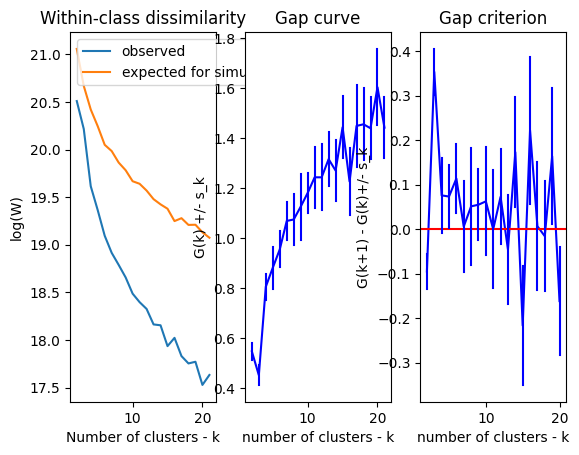

<Figure size 1200x900 with 0 Axes>

In [22]:
# minimum of 2 clusters
list_cluster = 2 + np.arange(20)
Nsim = 20
W = np.zeros(len(list_cluster))
Wu = np.zeros((len(list_cluster), Nsim))
silhouette_scores = []
[N, p] = encoded.shape
minX = list(np.min(encoded, axis=0)) # data range min
maxX = list(np.max(encoded, axis=0)) # data range max
for idx, i in enumerate(list_cluster):
    kmeans = KMeans(n_clusters = i, init = "random", n_init = 10, random_state = 0).fit(encoded)
    # Within class dissimilarity
    kmeans.fit_predict(encoded)
    W[idx] = np.sum([len(encoded[kmeans.labels_ == k]) * np.sum(np.linalg.norm(encoded[kmeans.labels_ == k] - kmeans.cluster_centers_[k], axis = 1)) for k in range(i)])
    silhouette_scores.append(silhouette_score(encoded, kmeans.labels_))
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        # perform K-means on the simulated data
        kmeans_sim = kmeans_ae = KMeans(n_clusters = i, init = "random", n_init = 10, random_state = 0)
        kmeans_sim.fit_predict(Xu)
        # Within class dissimilarity (the simulated data)
        Wu[idx,j] = np.sum([len(Xu[kmeans_sim.labels_ == k]) * np.sum(np.linalg.norm(Xu[kmeans_sim.labels_ == k] - kmeans_sim.cluster_centers_[k], axis = 1)) for k in range(i)])

# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
fig, ax = plt.subplots(1, 3)
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) 
x_range = np.array(list_cluster)

# Plot the log within class scatters
ax[0].set_title("Within-class dissimilarity")
ax[0].plot(x_range, np.log(W), label='observed')
ax[0].plot(x_range, Elog_Wu, label='expected for simulation')
ax[0].legend(loc='upper left')
ax[0].set_xlabel("Number of clusters - k")
ax[0].set_ylabel("log(W)")

 # plot the Gap curve
ax[1].set_title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
ax[1].plot(x_range,Gk,color='blue')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
ax[1].plot(x_range_list, GkList, color='blue')
ax[1].set_ylabel('G(k) +/- s_k')
ax[1].set_xlabel('number of clusters - k')

# plot the Gap criterion
x_range_crit = x_range[:-1]
ax[2].set_title('Gap criterion')
Gk_crit =  Gk[1:] - Gk[:-1]
sk_crit = sk[1:]
ax[2].plot(x_range_crit, Gk_crit, color='blue')
x_range_list = []
x_range_list.append(x_range_crit)
x_range_list.append(x_range_crit)
GkList = []
GkList.append(Gk_crit-sk_crit)
GkList.append(Gk_crit+sk_crit)
ax[2].axhline(0, color = 'red')
ax[2].plot(x_range_list, GkList, color='blue')
ax[2].set_ylabel('G(k+1) - G(k)+/- s_k')
ax[2].set_xlabel('number of clusters - k')
plt.figure(figsize=(12,9))
plt.tight_layout()
plt.show()

In [23]:
# Implementation of the rule for estimating K*, see ESL (14.39), p. 519
K_opt = np.where(np.array(Gk[:-1]) >= np.array(Gk[1:] - sk[1:]))[0]

if not K_opt.size:
    K_opt = np.max(list_cluster)
    print ("Gap-statistic, optimal K = %d" % K_opt)
else:    
    print ("Gap-statistic, optimal K = %d" % list_cluster[K_opt[0]])

Gap-statistic, optimal K = 2


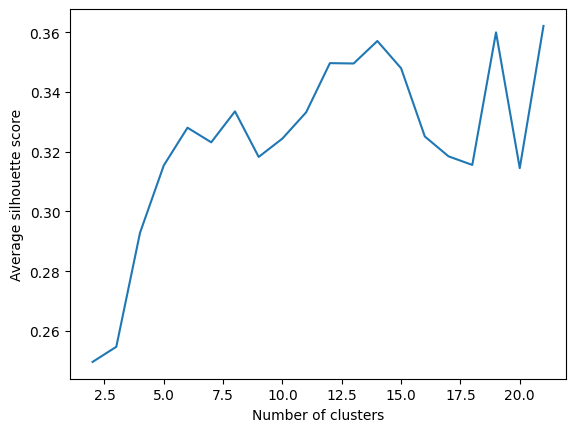

In [25]:
plt.plot(list_cluster, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette score')
plt.show()